In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [174]:
# read dataset and labels
data = pd.read_csv('data/CATSnDOGS.csv')/255
labels = pd.read_csv('data/Labels.csv')

In [175]:
# Slice image into patches
def extract_patches(image, patch_size):
    patches = []
    image = image.values.reshape(64, 64).T
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]]
            patches.append(patch)
    return patches


In [195]:
# Extract nxn patches from the images
img_size = 64
row_splits = 4
col_splits = row_splits
number_patches = row_splits * col_splits
patch_size = (int(img_size/row_splits), int(img_size/col_splits))

# Extract patches from all images
patches = []
for i in range(data.shape[0]):
    patches.append(extract_patches(data.iloc[i], patch_size))

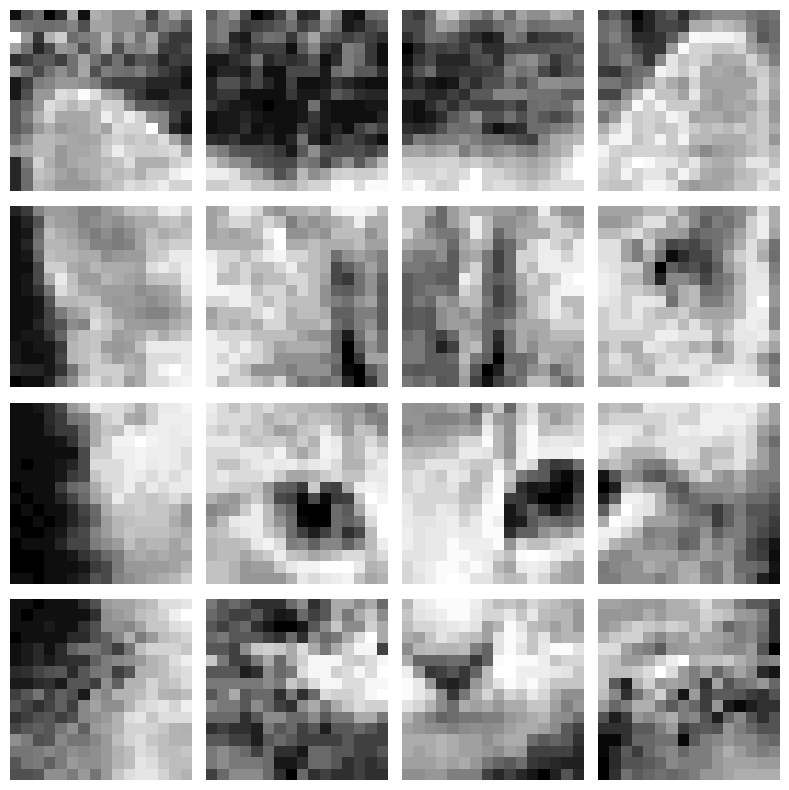

In [196]:
# plot one image split into nxn patches
image_idx = 0
fig, axes = plt.subplots(row_splits, col_splits, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(patches[image_idx][i], cmap='gray')
    ax.axis('off')
fig.tight_layout()
plt.show()

In [197]:
shape_of_data = np.array(patches).shape # (image_nr, patch_nr, patch_size[0], patch_size[1])

In [199]:
# Classifying with logistic regression using one patch per image
X = np.array(patches)
y = labels['x'].values

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

accuracies_from_multiple_runs = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    accuracies = []
    for patch in range(X.shape[1]):
        X_train_patch = np.reshape(X_train[:, patch],(-1, shape_of_data[2]*shape_of_data[3]))
        X_test_patch = np.reshape(X_test[:, patch],(-1, shape_of_data[2]*shape_of_data[3]))
        
        clf_KNN = KNeighborsClassifier(n_neighbors=3)
        clf_RF = RandomForestClassifier(n_estimators=50)
        clf_KNN.fit(X_train_patch, y_train)
        clf_RF.fit(X_train_patch, y_train)
        y_pred_KNN = clf_KNN.predict(X_test_patch)
        y_pred_RF = clf_RF.predict(X_test_patch)
        
        accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
        accuracy_RF = accuracy_score(y_test, y_pred_RF)
        accuracies.append([accuracy_KNN, accuracy_RF])
    
    accuracies = np.array(accuracies).reshape(2, row_splits, col_splits)
    accuracies_from_multiple_runs.append(accuracies)

In [200]:
# Print mean values of accuracies
mean_accuracies = np.mean(accuracies_from_multiple_runs, axis=0)
print(mean_accuracies)

[[[0.68475 0.6985  0.69725 0.6965 ]
  [0.68275 0.68125 0.715   0.70375]
  [0.5605  0.63275 0.653   0.7095 ]
  [0.6825  0.68775 0.5585  0.58675]]

 [[0.5405  0.559   0.62725 0.68025]
  [0.6205  0.69725 0.50425 0.53925]
  [0.533   0.5305  0.622   0.64125]
  [0.59225 0.6665  0.5285  0.58075]]]


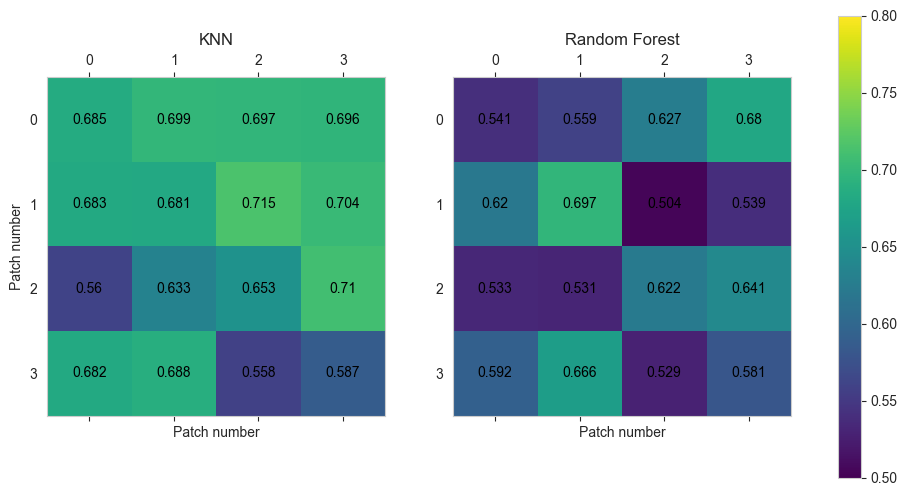

In [213]:
# Plot the mean accuracies of each model using a heatmap
fig, ax = plt.subplots(1,2, figsize=(12, 6))
cax = ax[0].matshow(mean_accuracies[0], cmap='viridis', vmin=.5, vmax=.8)
ax[0].set_xlabel('Patch number')
ax[0].set_ylabel('Patch number')
ax[1].matshow(mean_accuracies[1], cmap='viridis', vmin=.5, vmax=.8)
ax[1].set_xlabel('Patch number')
# add title
ax[0].set_title('KNN')
ax[1].set_title('Random Forest')

# Plot the values in the heatmap
for n in range(2):
    for i in range(row_splits):
        for j in range(col_splits):
            ax[n].text(j, i, round(mean_accuracies[n, i, j], 3), ha='center', va='center', color='black')

fig.colorbar(cax, ax=ax)
ax[0].grid(False)
ax[1].grid(False)
plt.show()
